# CNN-VAE on HUTUBS dataset (Chen et al. 2019)

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display
from pysofaconventions import *

from utils_data import load_hutubs_yamo
from utils_model_1d import create_autoencoder_dense, create_autoencoder_resnet, create_autoencoder_inception, \
                           create_cvae_dense, create_cvae_resnet, create_cvae_inception
from utils_train import train_model
from utils_plot import plot_reconstructions_chen2019, plot_reconstructions_cvae, \
                       plot_xcorr, plot_xcorr_cvae, plot_latent_space

In [42]:
## some useful functions
def normalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n -= x_mean
    hrtf_n /= x_std
    return hrtf_n

def denormalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n *= x_std
    hrtf_n += x_mean
    return hrtf_n

## Load data

In [43]:
# show all possible setups
import scipy.io as sio
azimuths = sio.loadmat('./HRTF data for DL/azimuth.mat')['azimuth'][0]  ## The previous 'azimuth.mat' and 'elevation.mat' are cell arrays, that's not correct. I resaved them as normal arrays. Also, they need to be 1xN arrays.   
elevations = sio.loadmat('./HRTF data for DL/elevation.mat')['elevation'][0]
freqs = sio.loadmat('./HRTF data for DL/freq_matlab.mat')['X'][0]
# print(azimuths) 
# print(elevations)
# print(len(azimuths[::5]) * (len(elevations[::2])-2))

In [44]:
from utils_data import load_hutubs_yamo

# load HRTFs from HUTUBS 
filters = {
    'ears': ['left'],
    #'ids': range(1,31),
    'azimuth': (np.arange(-70,70,2) % 360),
    'elevation': np.arange(-40,40,10)    # elevation reoslution: 10 degrees
}

# print(filters)
(x_train, y_train),(x_test, y_test)=load_hutubs_yamo(
    #dataset_path='./Studienarbeit_test/',
    dataset_path='./HRTF data for DL', 
    anthropometrics_path='./HRTF data for DL/AntrhopometricMeasures.csv', 
    data_content='hrtfs',
    user_filters=filters
)
print(x_train)
# remove neighbors
x_train = x_train[:,3,3,:]
x_test = x_test[:,3,3,:]

{'ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], 'ears': ['left'], 'azimuth': array([290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314,
       316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340,
       342, 344, 346, 348, 350, 352, 354, 356, 358,   0,   2,   4,   6,
         8,  10,  12,  14,  16,  18,  20,  22,  24,  26,  28,  30,  32,
        34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
        60,  62,  64,  66,  68], dtype=int32), 'elevation': array([-40, -30, -20, -10,   0,  10,  20,  30])}
Train/test split: 72/24 ids


  0%|          | 0/53760 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


  0%|          | 47/53760 [00:00<01:55, 463.58it/s]

48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


  0%|          | 148/53760 [00:00<01:48, 494.65it/s]

94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13


  0%|          | 198/53760 [00:00<01:57, 457.11it/s]

14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


  0%|          | 254/53760 [00:00<01:49, 489.16it/s]

66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


  1%|          | 319/53760 [00:00<01:39, 539.07it/s]

144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13


  1%|          | 435/53760 [00:00<01:36, 550.54it/s]

14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


  1%|          | 555/53760 [00:01<01:33, 571.40it/s]

136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


  1%|▏         | 688/53760 [00:01<01:25, 618.83it/s]

83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


  1%|▏         | 751/53760 [00:01<01:39, 535.14it/s]

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


  2%|▏         | 807/53760 [00:01<01:39, 530.82it/s]

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


  2%|▏         | 865/53760 [00:01<01:37, 543.18it/s]

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


  2%|▏         | 921/53760 [00:01<01:39, 532.55it/s]

17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


  2%|▏         | 976/53760 [00:01<01:41, 522.37it/s]

57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


  2%|▏         | 1038/53760 [00:01<01:36, 547.00it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5


  2%|▏         | 1096/53760 [00:02<01:34, 556.03it/s]

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


  2%|▏         | 1156/53760 [00:02<01:32, 568.42it/s]

83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


  2%|▏         | 1218/53760 [00:02<01:30, 582.41it/s]

130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


  2%|▏         | 1278/53760 [00:02<01:29, 583.53it/s]

28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


  2%|▏         | 1337/53760 [00:02<01:31, 572.92it/s]

77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


  3%|▎         | 1395/53760 [00:02<01:40, 523.10it/s]

133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


  3%|▎         | 1450/53760 [00:02<01:38, 530.21it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


  3%|▎         | 1512/53760 [00:02<01:34, 554.60it/s]

62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


  3%|▎         | 1576/53760 [00:02<01:30, 576.23it/s]

105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


  3%|▎         | 1635/53760 [00:02<01:31, 572.23it/s]

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


  3%|▎         | 1696/53760 [00:03<01:29, 581.98it/s]

52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


  3%|▎         | 1817/53760 [00:03<01:35, 544.95it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


  4%|▎         | 1882/53760 [00:03<01:30, 571.61it/s]

121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1


  4%|▎         | 1940/53760 [00:03<01:32, 557.31it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


  4%|▍         | 2061/53760 [00:03<01:29, 575.98it/s]

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


  4%|▍         | 2119/53760 [00:03<01:38, 525.63it/s]

171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


  4%|▍         | 2174/53760 [00:03<01:37, 531.24it/s]

47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


  4%|▍         | 2228/53760 [00:04<01:38, 524.79it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


  4%|▍         | 2282/53760 [00:04<01:37, 527.96it/s]

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


  4%|▍         | 2337/53760 [00:04<01:36, 534.13it/s]

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


  4%|▍         | 2400/53760 [00:04<01:31, 558.97it/s]

97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


  5%|▍         | 2459/53760 [00:04<01:30, 566.89it/s]

171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


  5%|▍         | 2518/53760 [00:04<01:29, 572.29it/s]

49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


  5%|▍         | 2576/53760 [00:04<01:40, 511.32it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


  5%|▍         | 2636/53760 [00:04<01:35, 532.86it/s]

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


  5%|▌         | 2691/53760 [00:04<01:37, 521.50it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


  5%|▌         | 2754/53760 [00:05<01:32, 550.63it/s]

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


  5%|▌         | 2810/53760 [00:05<01:51, 457.89it/s]

165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


  5%|▌         | 2859/53760 [00:05<02:00, 424.16it/s]

42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


  5%|▌         | 2911/53760 [00:05<01:54, 444.82it/s]

73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


  6%|▌         | 2969/53760 [00:05<01:46, 478.69it/s]

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12


  6%|▌         | 3079/53760 [00:05<01:38, 513.15it/s]

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


  6%|▌         | 3132/53760 [00:05<01:40, 505.43it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


  6%|▌         | 3187/53760 [00:05<01:37, 517.86it/s]

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


  6%|▌         | 3313/53760 [00:06<01:27, 574.05it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


  6%|▋         | 3439/53760 [00:06<01:24, 595.43it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


  7%|▋         | 3565/53760 [00:06<01:23, 603.10it/s]

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


  7%|▋         | 3626/53760 [00:06<01:24, 596.77it/s]

96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


  7%|▋         | 3686/53760 [00:06<01:25, 586.26it/s]

166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


  7%|▋         | 3745/53760 [00:06<01:34, 531.65it/s]

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


  7%|▋         | 3804/53760 [00:07<01:31, 547.19it/s]

94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


  7%|▋         | 3864/53760 [00:07<01:28, 560.91it/s]

140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


  7%|▋         | 3922/53760 [00:07<01:28, 566.25it/s]

45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


  8%|▊         | 4041/53760 [00:07<01:25, 579.78it/s]

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


  8%|▊         | 4100/53760 [00:07<01:28, 559.24it/s]

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


  8%|▊         | 4163/53760 [00:07<01:25, 578.37it/s]

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


  8%|▊         | 4222/53760 [00:07<01:25, 580.57it/s]

156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


  8%|▊         | 4281/53760 [00:07<01:36, 515.21it/s]

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


  8%|▊         | 4334/53760 [00:08<01:53, 435.21it/s]

105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


  8%|▊         | 4381/53760 [00:08<01:52, 440.19it/s]

126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


  8%|▊         | 4489/53760 [00:08<01:42, 479.35it/s]

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


  8%|▊         | 4548/53760 [00:08<01:36, 508.48it/s]

136
137
138
139
140
141
142
143
144
145
146
147
148


  9%|▊         | 4601/53760 [00:08<01:46, 462.83it/s]

149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


  9%|▊         | 4649/53760 [00:08<02:08, 382.83it/s]

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


  9%|▊         | 4691/53760 [00:08<02:24, 338.92it/s]

106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


  9%|▉         | 4762/53760 [00:09<02:42, 302.44it/s]

153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


  9%|▉         | 4794/53760 [00:09<03:51, 211.12it/s]

34
35
36
37
38
39
40
41
42


  9%|▉         | 4831/53760 [00:09<03:23, 240.48it/s]

43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


  9%|▉         | 4883/53760 [00:09<02:43, 299.00it/s]

103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


  9%|▉         | 4935/53760 [00:09<02:19, 349.37it/s]

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


  9%|▉         | 4992/53760 [00:09<02:00, 403.74it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


  9%|▉         | 5058/53760 [00:10<01:43, 469.70it/s]

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


 10%|▉         | 5122/53760 [00:10<01:34, 515.68it/s]

175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


 10%|▉         | 5185/53760 [00:10<01:29, 545.50it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


 10%|▉         | 5299/53760 [00:10<01:34, 512.58it/s]

139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


 10%|█         | 5415/53760 [00:10<01:33, 516.65it/s]

55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175


 10%|█         | 5475/53760 [00:10<01:29, 539.00it/s]

176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


 10%|█         | 5531/53760 [00:11<02:17, 351.98it/s]

47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


 10%|█         | 5576/53760 [00:11<02:56, 273.44it/s]

119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


 10%|█         | 5612/53760 [00:11<03:20, 239.70it/s]

152
153
154
155
156
157
158
159
160
161
162
163
164


 10%|█         | 5643/53760 [00:11<03:21, 238.39it/s]

165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


 11%|█         | 5715/53760 [00:11<02:52, 279.04it/s]

52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


 11%|█         | 5747/53760 [00:12<02:51, 279.61it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


 11%|█         | 5803/53760 [00:12<02:18, 347.45it/s]

116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14


 11%|█         | 5850/53760 [00:12<02:07, 376.49it/s]

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


 11%|█         | 5891/53760 [00:12<02:21, 339.42it/s]

77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


 11%|█         | 5928/53760 [00:12<03:04, 259.25it/s]

117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


 11%|█         | 5959/53760 [00:12<03:12, 247.91it/s]

152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4


 11%|█         | 6020/53760 [00:12<02:56, 270.70it/s]

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


 11%|█▏        | 6111/53760 [00:13<02:13, 357.05it/s]

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


 11%|█▏        | 6157/53760 [00:13<02:04, 382.82it/s]

128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


 12%|█▏        | 6197/53760 [00:13<02:05, 378.22it/s]

38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


 12%|█▏        | 6240/53760 [00:13<02:01, 392.60it/s]

78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


 12%|█▏        | 6281/53760 [00:13<02:03, 384.41it/s]

119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


 12%|█▏        | 6321/53760 [00:13<02:08, 370.38it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


 12%|█▏        | 6361/53760 [00:13<02:06, 375.78it/s]

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


 12%|█▏        | 6399/53760 [00:13<02:13, 354.17it/s]

56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


 12%|█▏        | 6479/53760 [00:14<02:15, 349.76it/s]

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


 12%|█▏        | 6518/53760 [00:14<02:11, 359.10it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6


 12%|█▏        | 6556/53760 [00:14<02:09, 363.17it/s]

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


 12%|█▏        | 6593/53760 [00:14<02:14, 351.13it/s]

70
71
72
73
74
75
76
77
78
79
80
81


 12%|█▏        | 6629/53760 [00:14<02:16, 346.54it/s]

82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


 12%|█▏        | 6666/53760 [00:14<02:14, 351.42it/s]

139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


 12%|█▏        | 6703/53760 [00:14<02:12, 355.61it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


 13%|█▎        | 6745/53760 [00:14<02:05, 373.93it/s]

39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


 13%|█▎        | 6792/53760 [00:15<01:57, 400.19it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


 13%|█▎        | 6837/53760 [00:15<01:53, 411.65it/s]

128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


 13%|█▎        | 6882/53760 [00:15<01:51, 421.98it/s]

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


 13%|█▎        | 6932/53760 [00:15<01:45, 444.67it/s]

43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


 13%|█▎        | 6987/53760 [00:15<01:38, 474.43it/s]

69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 13%|█▎        | 7098/53760 [00:15<01:32, 503.16it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


 13%|█▎        | 7207/53760 [00:15<01:38, 471.01it/s]

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3


 14%|█▎        | 7314/53760 [00:16<01:34, 488.93it/s]

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


 14%|█▍        | 7427/53760 [00:16<01:29, 517.76it/s]

119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


 14%|█▍        | 7540/53760 [00:16<01:25, 537.50it/s]

54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


 14%|█▍        | 7657/53760 [00:16<01:22, 560.39it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


 14%|█▍        | 7773/53760 [00:16<01:22, 559.05it/s]

109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


 15%|█▍        | 7894/53760 [00:17<01:19, 579.99it/s]

56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5


 15%|█▍        | 8012/53760 [00:17<01:19, 574.61it/s]

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


 15%|█▌        | 8129/53760 [00:17<01:21, 561.41it/s]

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


 15%|█▌        | 8186/53760 [00:17<01:35, 474.79it/s]

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142


 15%|█▌        | 8293/53760 [00:17<01:30, 500.50it/s]

143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


 16%|█▌        | 8396/53760 [00:18<01:33, 483.48it/s]

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3


 16%|█▌        | 8567/53760 [00:18<01:23, 538.78it/s]

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


 16%|█▌        | 8625/53760 [00:18<01:23, 540.49it/s]

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


 16%|█▋        | 8741/53760 [00:18<01:24, 535.83it/s]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


 16%|█▋        | 8863/53760 [00:18<01:20, 559.11it/s]

171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


 17%|█▋        | 8983/53760 [00:19<01:19, 561.15it/s]

114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


 17%|█▋        | 9105/53760 [00:19<01:16, 583.03it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


 17%|█▋        | 9164/53760 [00:19<01:38, 452.55it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


 17%|█▋        | 9214/53760 [00:19<01:53, 392.32it/s]

37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


 17%|█▋        | 9299/53760 [00:19<02:05, 354.38it/s]

99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


 17%|█▋        | 9337/53760 [00:20<02:14, 329.21it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


 18%|█▊        | 9441/53760 [00:20<02:17, 322.22it/s]

45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


 18%|█▊        | 9474/53760 [00:20<02:17, 322.78it/s]

114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3


 18%|█▊        | 9554/53760 [00:20<02:02, 360.23it/s]

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


 18%|█▊        | 9654/53760 [00:20<01:43, 425.78it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5


 18%|█▊        | 9742/53760 [00:21<01:49, 400.26it/s]

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


 18%|█▊        | 9831/53760 [00:21<01:50, 398.46it/s]

96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 18%|█▊        | 9922/53760 [00:21<01:44, 421.42it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


 19%|█▊        | 10026/53760 [00:21<01:33, 469.23it/s]

99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12


 19%|█▊        | 10074/53760 [00:22<01:50, 395.92it/s]

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


 19%|█▉        | 10154/53760 [00:22<02:04, 349.14it/s]

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


 19%|█▉        | 10191/53760 [00:22<02:13, 325.83it/s]

138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7


 19%|█▉        | 10266/53760 [00:22<02:16, 318.92it/s]

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


 19%|█▉        | 10361/53760 [00:22<01:51, 389.46it/s]

95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


 19%|█▉        | 10450/53760 [00:23<01:43, 418.13it/s]

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


 20%|█▉        | 10561/53760 [00:23<01:31, 471.37it/s]

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


 20%|█▉        | 10726/53760 [00:23<01:22, 520.84it/s]

55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


 20%|██        | 10779/53760 [00:23<01:24, 509.26it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


 20%|██        | 10894/53760 [00:23<01:19, 540.01it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


 20%|██        | 11001/53760 [00:24<01:40, 425.99it/s]

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


 21%|██        | 11047/53760 [00:24<01:49, 390.71it/s]

90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


 21%|██        | 11137/53760 [00:24<01:42, 417.01it/s]

161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


 21%|██        | 11222/53760 [00:24<01:47, 397.18it/s]

69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


 21%|██        | 11321/53760 [00:24<01:34, 446.99it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


 21%|██        | 11367/53760 [00:25<01:45, 400.61it/s]

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


 21%|██▏       | 11448/53760 [00:25<02:05, 336.19it/s]

146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


 21%|██▏       | 11530/53760 [00:25<01:53, 371.64it/s]

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


 22%|██▏       | 11625/53760 [00:25<01:40, 418.56it/s]

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


 22%|██▏       | 11724/53760 [00:25<01:32, 453.29it/s]

43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


 22%|██▏       | 11816/53760 [00:26<01:35, 438.11it/s]

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


 22%|██▏       | 11910/53760 [00:26<01:47, 390.73it/s]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


 22%|██▏       | 11992/53760 [00:26<01:45, 395.60it/s]

136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


 22%|██▏       | 12086/53760 [00:26<01:42, 408.39it/s]

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


 23%|██▎       | 12181/53760 [00:27<01:34, 438.55it/s]

133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


 23%|██▎       | 12293/53760 [00:27<01:23, 496.47it/s]

56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


 23%|██▎       | 12400/53760 [00:27<01:21, 505.38it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


 23%|██▎       | 12456/53760 [00:27<01:19, 520.22it/s]

82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11


 23%|██▎       | 12565/53760 [00:27<01:18, 522.41it/s]

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


 24%|██▎       | 12673/53760 [00:28<01:19, 517.85it/s]

124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


 24%|██▍       | 12787/53760 [00:28<01:15, 541.84it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


 24%|██▍       | 12954/53760 [00:28<01:16, 535.30it/s]

172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


 24%|██▍       | 13009/53760 [00:28<01:15, 536.88it/s]

107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


 24%|██▍       | 13115/53760 [00:28<01:19, 511.84it/s]

38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


 25%|██▍       | 13224/53760 [00:29<01:27, 464.63it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


 25%|██▍       | 13338/53760 [00:29<01:18, 512.66it/s]

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3


 25%|██▌       | 13442/53760 [00:29<01:21, 496.62it/s]

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


 25%|██▌       | 13553/53760 [00:29<01:19, 507.45it/s]

104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


 25%|██▌       | 13667/53760 [00:29<01:14, 535.19it/s]

36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


 26%|██▌       | 13780/53760 [00:30<01:13, 541.91it/s]

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


 26%|██▌       | 13896/53760 [00:30<01:12, 550.10it/s]

86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


 26%|██▌       | 14006/53760 [00:30<01:15, 526.96it/s]

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


 26%|██▌       | 14059/53760 [00:30<01:27, 454.96it/s]

116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14


 26%|██▋       | 14160/53760 [00:30<01:24, 470.06it/s]

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


 27%|██▋       | 14267/53760 [00:31<01:20, 491.29it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


 27%|██▋       | 14371/53760 [00:31<01:23, 474.56it/s]

49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


 27%|██▋       | 14480/53760 [00:31<01:17, 504.69it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


 27%|██▋       | 14642/53760 [00:31<01:14, 525.13it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 27%|██▋       | 14757/53760 [00:32<01:10, 550.25it/s]

35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


 28%|██▊       | 14813/53760 [00:32<01:18, 496.23it/s]

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 28%|██▊       | 14927/53760 [00:32<01:13, 530.70it/s]

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11


 28%|██▊       | 15045/53760 [00:32<01:09, 558.00it/s]

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


 28%|██▊       | 15164/53760 [00:32<01:08, 562.20it/s]

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


 28%|██▊       | 15221/53760 [00:32<01:10, 544.71it/s]

74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


 29%|██▊       | 15377/53760 [00:33<01:21, 468.18it/s]

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


 29%|██▊       | 15426/53760 [00:33<01:32, 415.47it/s]

66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


 29%|██▉       | 15512/53760 [00:33<01:39, 385.62it/s]

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


 29%|██▉       | 15601/53760 [00:33<01:32, 413.38it/s]

44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


 29%|██▉       | 15689/53760 [00:34<01:34, 403.91it/s]

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


 29%|██▉       | 15783/53760 [00:34<01:27, 434.08it/s]

54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


 30%|██▉       | 15878/53760 [00:34<01:24, 447.29it/s]

156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


 30%|██▉       | 15974/53760 [00:34<01:22, 460.64it/s]

79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 30%|██▉       | 16070/53760 [00:34<01:27, 432.02it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


 30%|███       | 16172/53760 [00:35<01:20, 466.89it/s]

106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14


 30%|███       | 16270/53760 [00:35<01:23, 446.88it/s]

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


 30%|███       | 16367/53760 [00:35<01:27, 428.38it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9


 31%|███       | 16461/53760 [00:35<01:26, 432.41it/s]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


 31%|███       | 16505/53760 [00:36<01:41, 366.81it/s]

94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


 31%|███       | 16594/53760 [00:36<01:33, 396.54it/s]

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


 31%|███       | 16683/53760 [00:36<01:29, 415.57it/s]

79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


 31%|███       | 16773/53760 [00:36<01:26, 429.57it/s]

175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


 31%|███▏      | 16860/53760 [00:36<01:30, 406.73it/s]

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 31%|███▏      | 16896/53760 [00:36<01:20, 456.99it/s]


[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 3.75726448e-01 -9.04532492e-01 -1.00163745e+00 ... -1.48116058e+02
    -1.49087380e+02 -1.48895847e+02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 2.38527725e-01 -3.10418829e-01  2.01901600e+00 ... -1.37523700e+02
    -1.39071210e+02 -1.39121897e+02]
   [ 1.78939239e-

In [45]:
# normalize
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = normalize_hrtf(x_train, x_train_mean, x_train_std)
x_test = normalize_hrtf(x_test, x_train_mean, x_train_std)
print(x_train_mean, x_train_std)

# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

n_frequencies = x_train.shape[1]

-5.051040023902507 27.277764138824313
train set: (12672, 129)
test set:  (4224, 129)


In [46]:
# add normalized azimuth/elevation angles
stddeg = azimuths.std()
y_train['elevation_norm'] = y_train['elevation'] / stddeg
y_train['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_train['azimuth']]
y_test['elevation_norm'] = y_test['elevation'] / stddeg
y_test['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_test['azimuth']]

In [47]:
np.shape(x_train)
print(x_train[1000])

[0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.185

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


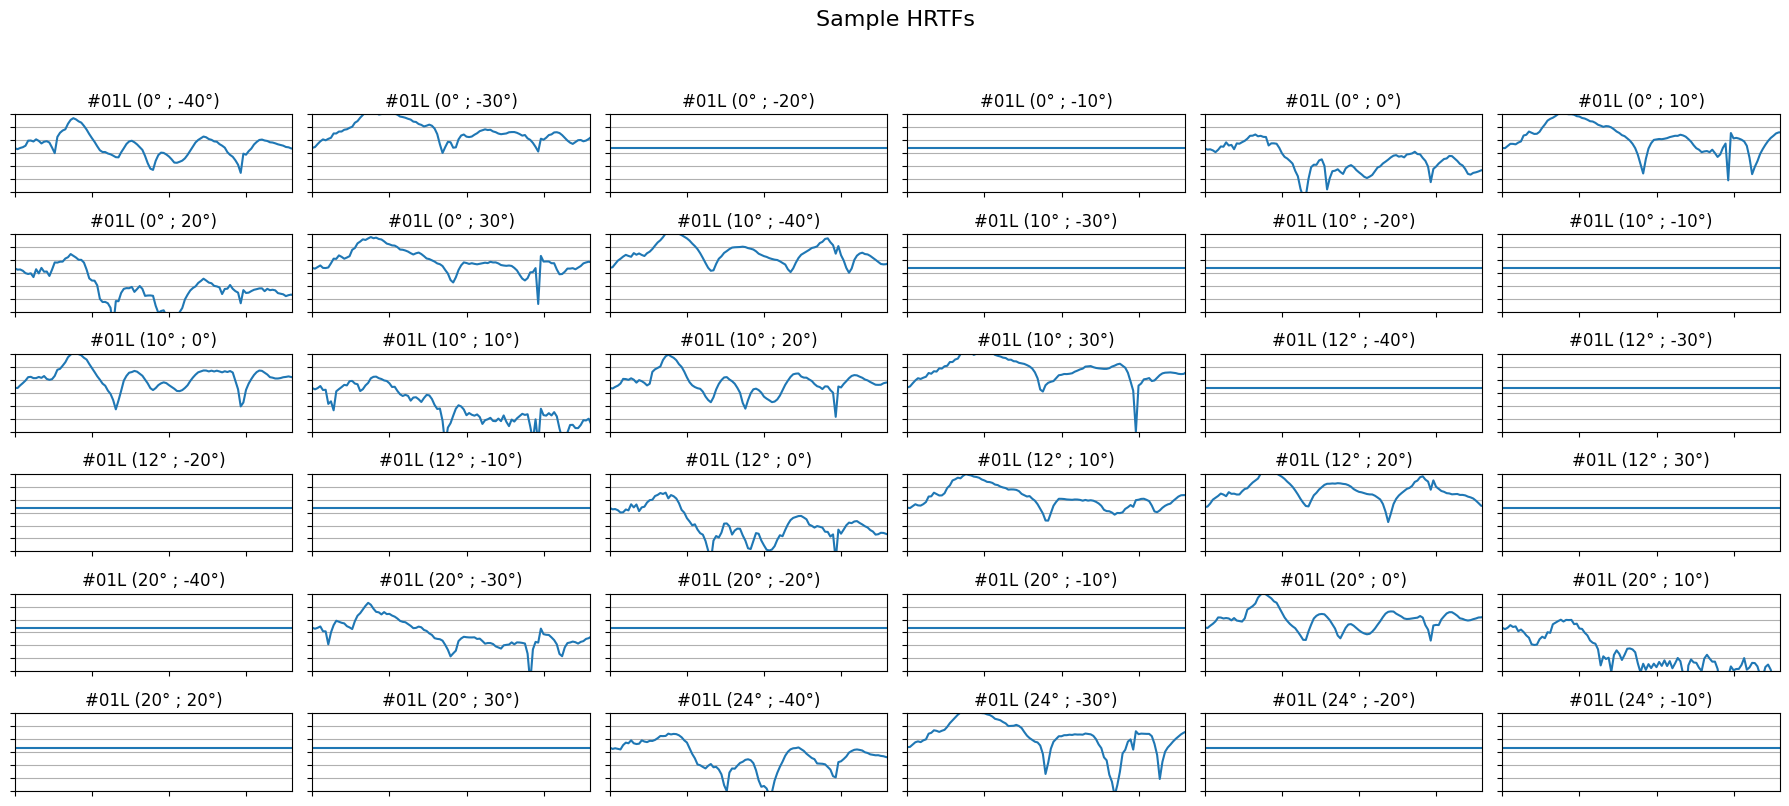

In [48]:
nr, nc = 6, 6
w = 18
h = w / 2.2
f = sio.loadmat('./HRTF data for DL/freq_matlab.mat')['X'][0]
offs = 30

fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    a.plot(f, x_train[i*100])
    a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
            y_train['id'].iloc[i], y_train['ear'].iloc[i][0].upper(),
            y_train['azimuth'].iloc[i], y_train['elevation'].iloc[i]))    
    a.set_ylim([-1.2, 1.2])
    a.set_xlim([0, 18000])
    a.set_yticks(np.arange(-1.5, 1.51, 0.5))
    a.yaxis.grid()
    a.set_yticklabels([])
    a.set_xticklabels([])
    #a.axis('off')
    print(i)
fig.suptitle('Sample HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])


## Create network

In [49]:
# network parameters
modelname = 'chen2019'
filters_layers = [256, 192, 128, 96, 64, 48, 32]
n_latent = 16

# create 1d net
encoder, decoder, vae = create_autoencoder_dense(n_input=n_frequencies, 
                                                  filters_layers=filters_layers, 
                                                  n_latent=n_latent,
                                                  gen_plots=True)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 encoder_0_dense (Dense)        (None, 256)          33280       ['encoder_input[0][0]']          
                                                                                                  
 encoder_0_bn (BatchNormalizati  (None, 256)         1024        ['encoder_0_dense[0][0]']        
 on)                                                                                              
                                                                                                  
 encoder_0_act (Activation)     (None, 256)          0           ['encoder_0_bn[0][0]']     

In [50]:
print(type(y_train))
print(type(y_test))

print(x_train.dtype)
print(x_test.dtype)

print(len(y_train))
print(len(y_test))

print(y_train.shape)
print(y_test.shape)

# print(y_train.loc[0])

print(y_train.keys())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
float64
float64
12672
4224
(12672, 32)
(4224, 32)
Index(['id', 'ear', 'ear_n', 'azimuth', 'elevation', 'x1', 'x2', 'x3', 'x4',
       'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x16', 'x17', 'd1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'theta1', 'theta2',
       'elevation_norm', 'azimuth_norm'],
      dtype='object')


## Train network

In [54]:
# training parameters
batch_size = x_train.shape[0] // 64
print(batch_size)
epochs = 200
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')

trainig_history = train_model(vae, x_train, y_train[['azimuth_norm', 'elevation_norm']], 
                              x_test, y_test[['azimuth_norm', 'elevation_norm']], 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

198
Training log: ./logs/77169767
Training from 0 to 200..
{'vae_input_hrtf': array([[ 0.18874392,  0.15041061,  0.19726422, ..., -5.98745   ,
        -6.31834   , -6.598813  ],
       [ 0.18460996,  0.16034925,  0.20842199, ..., -4.63876   ,
        -4.634663  , -4.651204  ],
       [ 0.1873303 ,  0.16215824,  0.18955383, ..., -4.435     ,
        -4.443948  , -4.4518204 ],
       ...,
       [ 0.1869556 ,  0.16705827,  0.23905806, ..., -5.609176  ,
        -5.710723  , -5.6933336 ],
       [ 0.18793796,  0.16219844,  0.24109858, ..., -4.7151814 ,
        -4.8849726 , -5.0012784 ],
       [ 0.18888079,  0.1639276 ,  0.22230665, ..., -4.459095  ,
        -4.3177466 , -5.518167  ]], dtype=float32), 'vae_input_position': array([[ 0.        , -0.38580173],
       [ 0.        , -0.2893513 ],
       [ 0.        , -0.19290087],
       ...,
       [-0.09645043,  0.09645043],
       [-0.09645043,  0.19290087],
       [-0.09645043,  0.2893513 ]], dtype=float32)}
{'vae_input_hrtf': array([[ 0.18

  0%|          | 0/200 [00:00<?, ?it/s]

loss: 0.1528, val_loss: 0.0518: 100%|██████████| 200/200 [05:29<00:00,  1.65s/it]


## Plot results

minimum loss:  0.1007903516292572


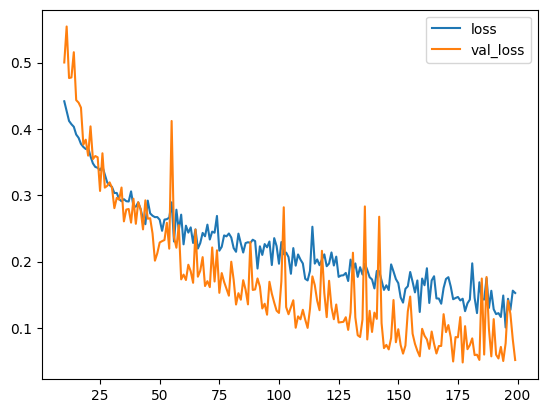

In [55]:
trainig_history.iloc[10:].plot()
print('minimum loss: ', trainig_history['loss'].min())

1/1 [==============================] - 0s 39ms/step


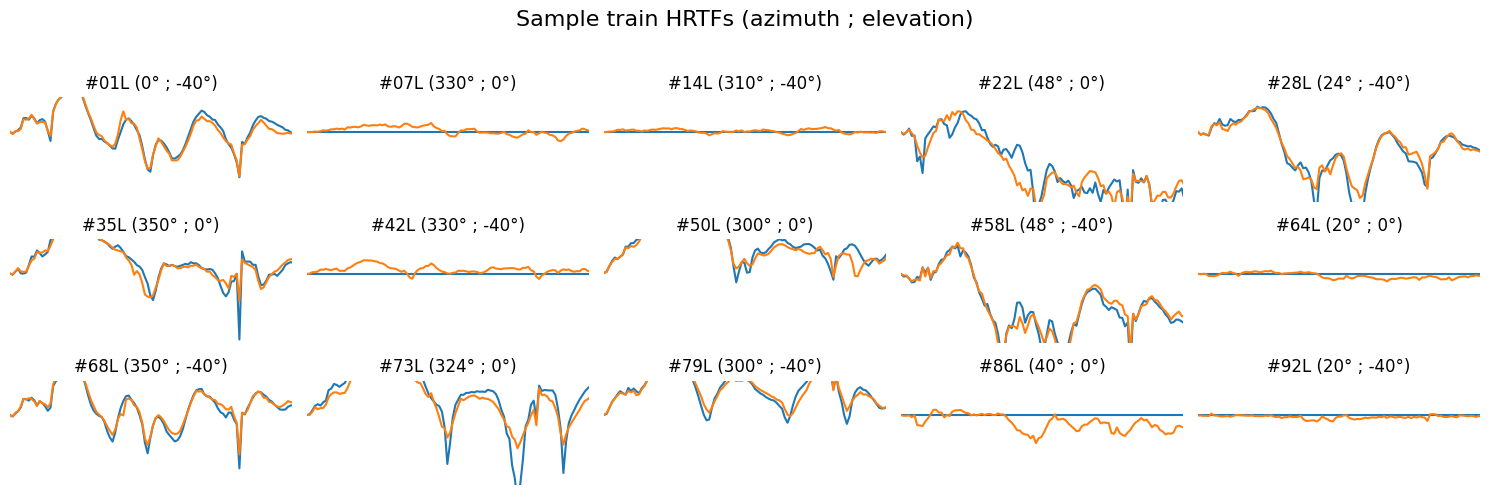

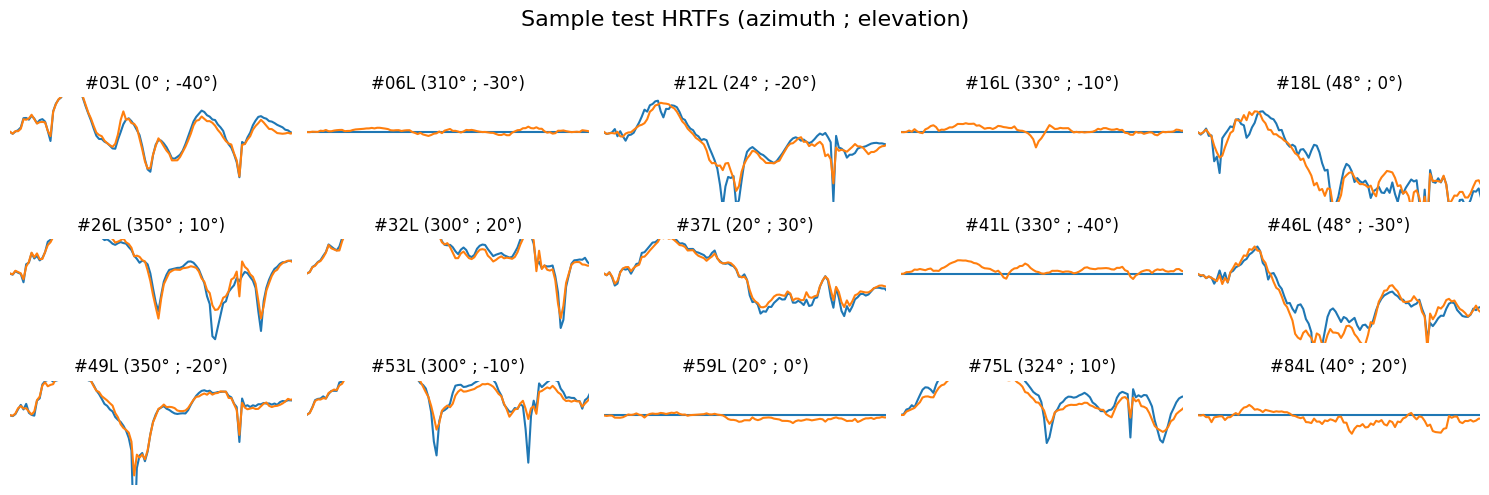

In [58]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

22/22 [==============================] - 0s 4ms/step


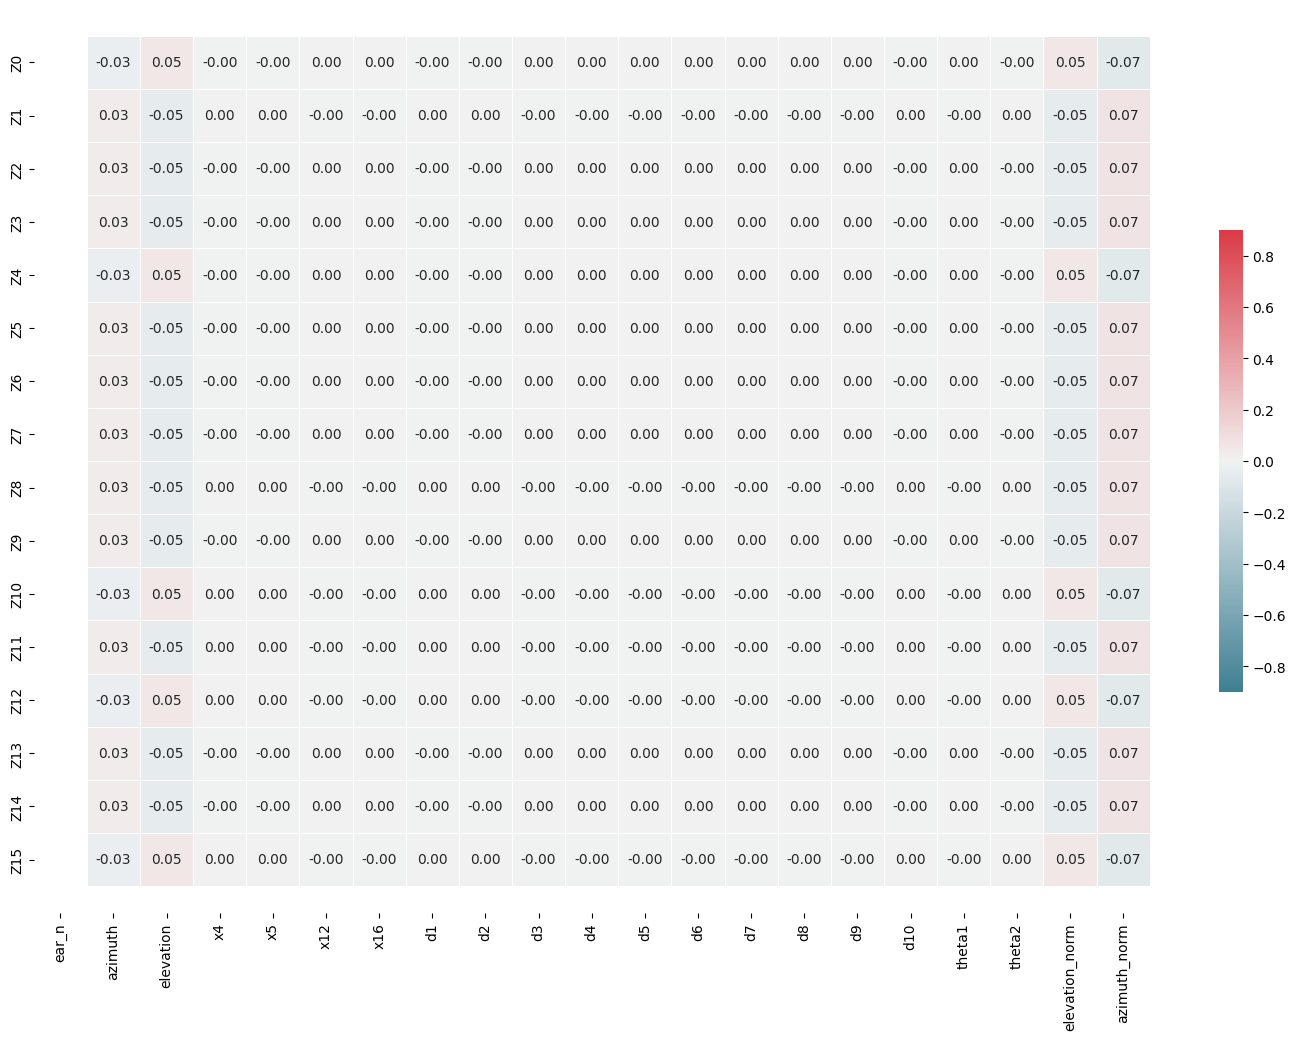

In [59]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
corr = plot_xcorr(encoder, data_test, ax,
           batch_size=batch_size, pca=False,
           labels=True)

In [61]:
def spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range):
    fmin, fmax = f_range
    # get bins in range
    f_idx = []
    for i,f in enumerate(freqs):
        if f > fmin and f < fmax:
            f_idx.append(i)
    # formula: sqrt(1/N * sum(square(H_true(f) - H_pred(f))))
    sd_db = np.sqrt((1/len(f_idx)) * np.sum(np.power(hrtf_true[:,f_idx] - hrtf_pred[:,f_idx], 2), axis=1))
    # dB to linear
    #sd = 10 ** (sd_db/20)
    return sd_db

# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_train, batch_size=512)
z_sample = np.concatenate((z_mean, y_train[['azimuth_norm', 'elevation_norm']]), axis=1)
z_sample = np.asarray(z_sample).astype('float32')

x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_train[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_train, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (train) = ', res_train['SD'].mean())

396/396 [==============================] - 2s 4ms/step
mean SD (train) =  4.1397786


In [63]:
# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_test, batch_size=512)
z_sample = np.concatenate((z_mean, y_test[['azimuth_norm', 'elevation_norm']]), axis=1)
z_sample = np.asarray(z_sample).astype('float32')
x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_test[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_test, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (test)= ', res_train['SD'].mean())

132/132 [==============================] - 1s 4ms/step
mean SD (test)=  3.9634228


C:\Users\root\AppData\Local\Temp\ipykernel_24296\1991301291.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
C:\Users\root\AppData\Local\Temp\ipykernel_24296\1991301291.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
C:\Users\root\AppData\Local\Temp\ipykernel_24296\1991301291.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whic

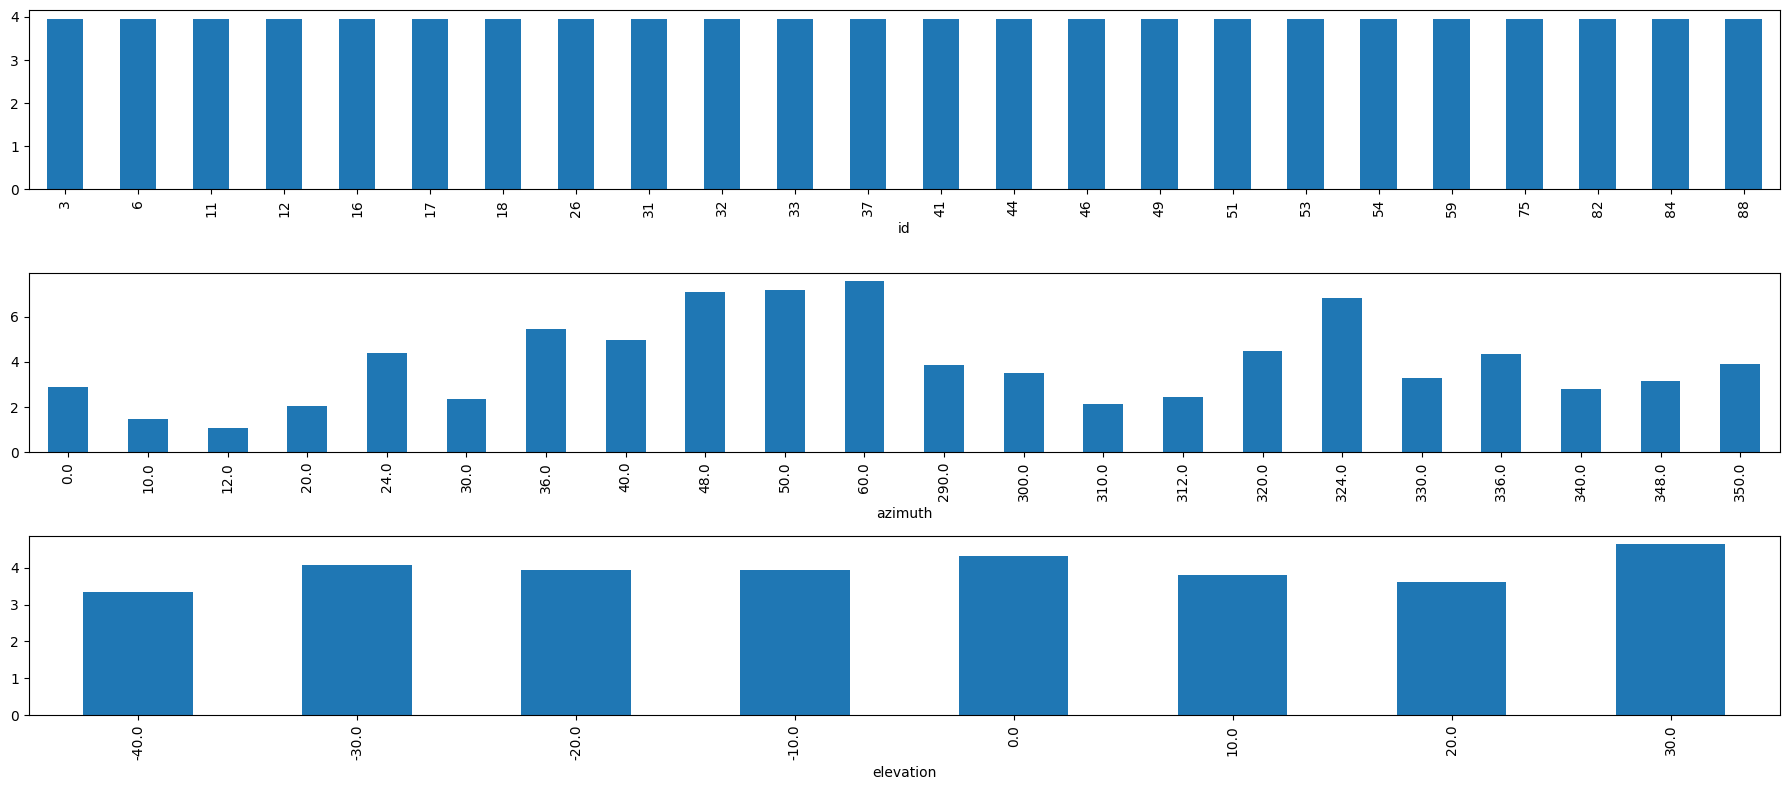

In [64]:
# spectral distortion on train data (various sub-groupings)
fig, axs = plt.subplots(3,1, figsize=(18,8))
res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
res_train.groupby(['elevation']).mean()['SD'].plot.bar(ax=axs[2])
fig.tight_layout()

34/64 [==============>...............] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


10/64 [===>..........................] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


 1/64 [..............................] - ETA: 2s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


32/64 [==============>...............] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


32/64 [==============>...............] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


36/64 [===============>..............] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


35/64 [===============>..............] - ETA: 0s

c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


64/64 [==============================] - 0s 3ms/step


c:\Users\root\miniconda3\envs\yuqing\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


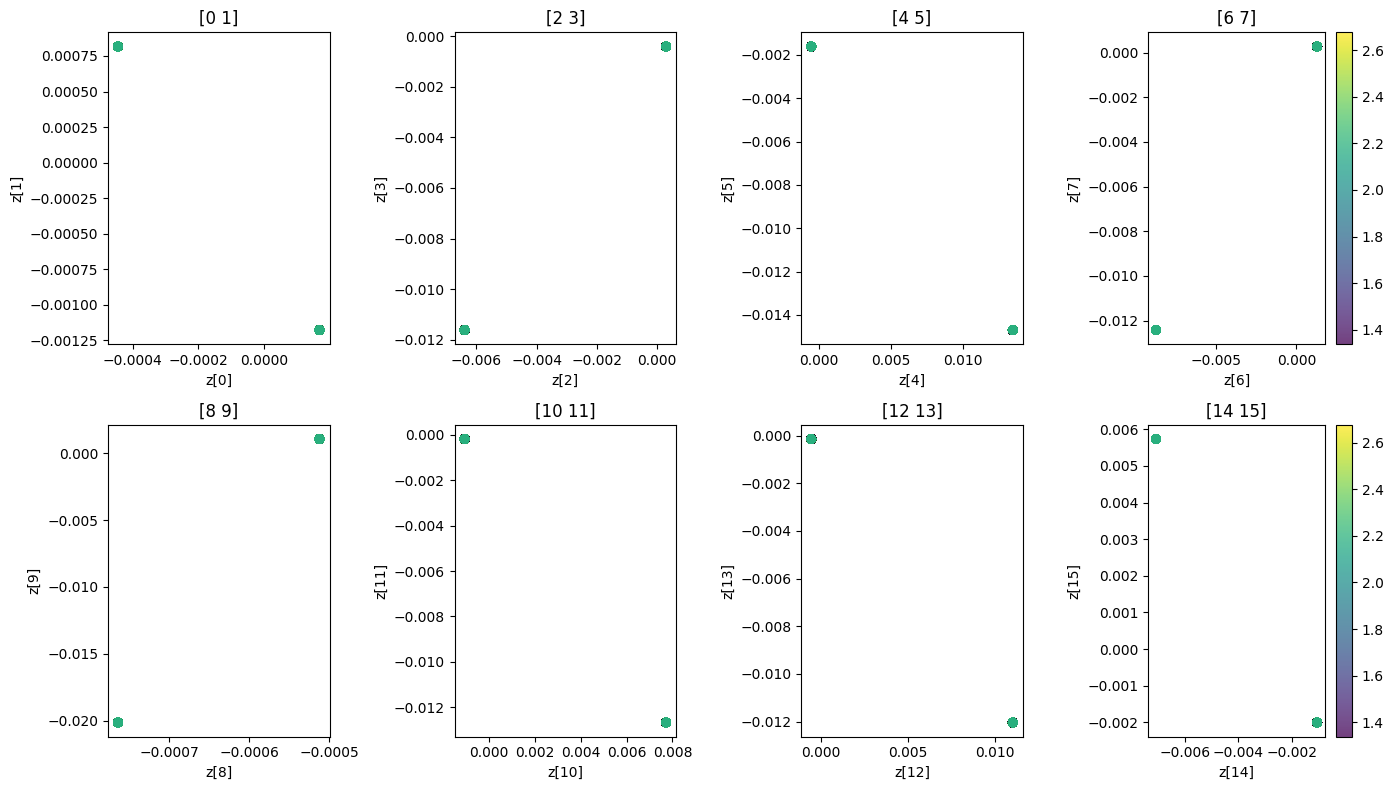

In [65]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, y_train['d4'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
for i, dims in enumerate(combinations):
#for dims in [[14, 15]]:
    dims += 0
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims,
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()

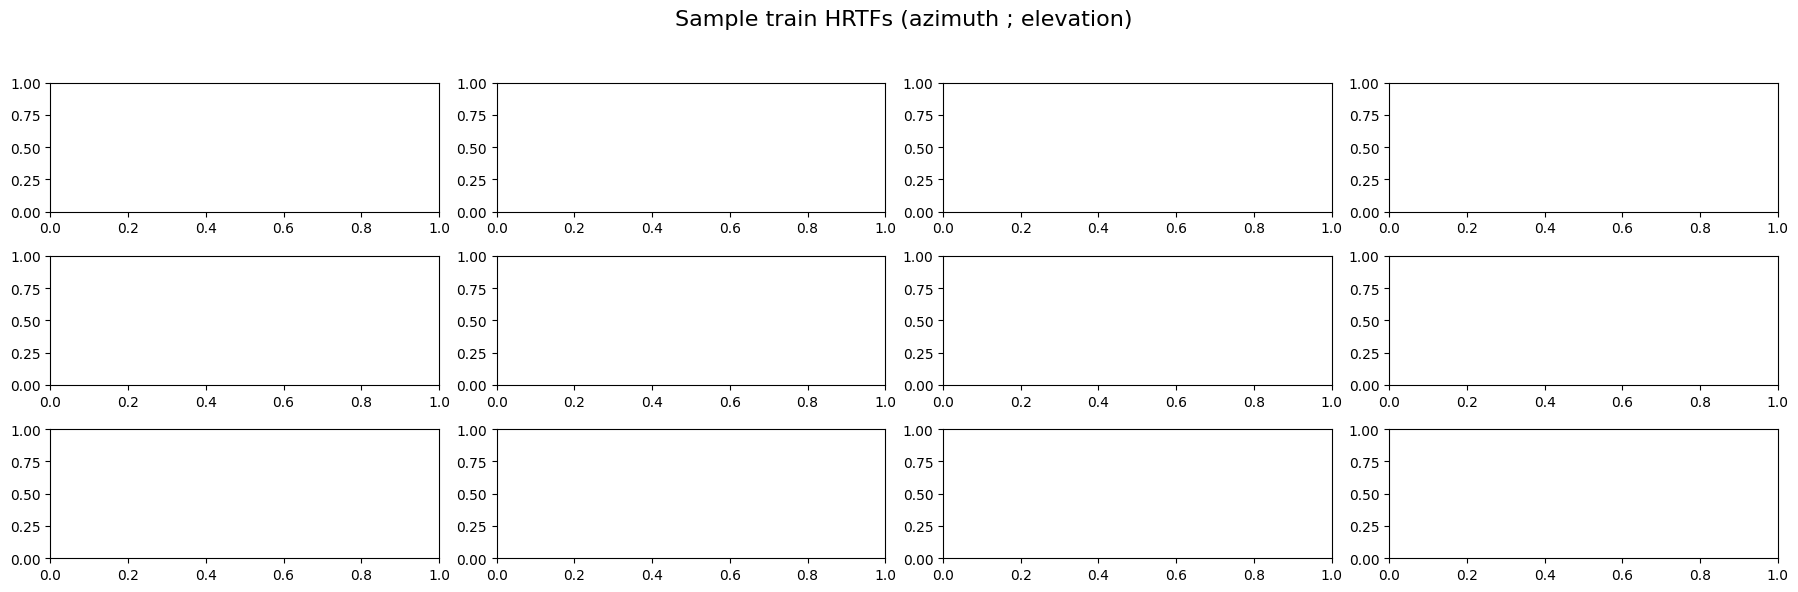

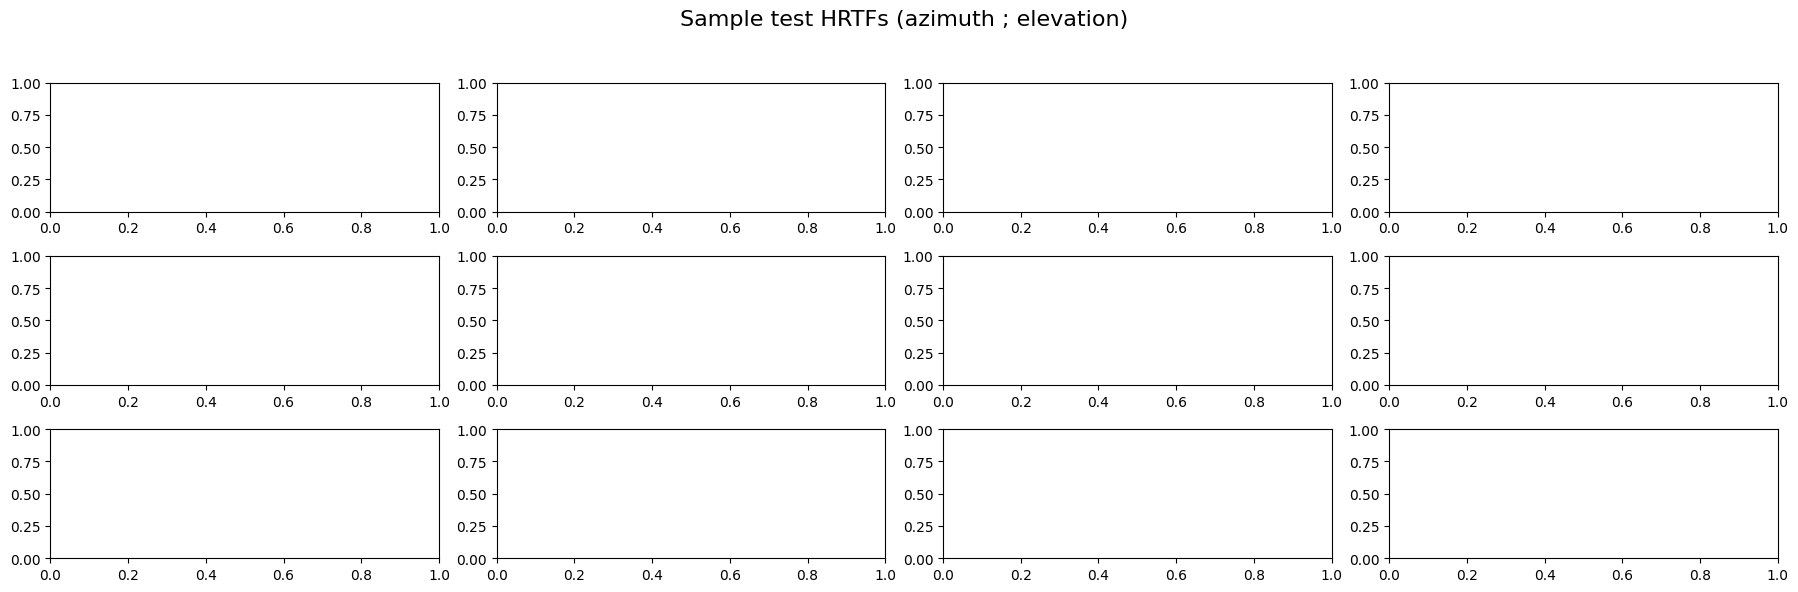

In [66]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

In [67]:
# plot PC
data_train = (x_train[::2], y_train['azimuth'].iloc[::2])
data_test = (x_test, y_test['elevation'])
plot_latent_pairs(encoder, data_train,
                  batch_size=batch_size, n_pca=False, n_dim=6, plot_kws=dict(edgecolor='none', alpha=0.5, s=15))

NameError: name 'plot_latent_pairs' is not defined

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

# - spetral distortion (500, 16k) Hz (viking paper)

In [10]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs_3d.pkl')